In [1]:
import numpy as np
import open3d as o3d
import transforms3d as t3d
from probreg import callbacks
import utils
import matplotlib.pyplot as plt
%matplotlib
from collections import namedtuple
from probreg import math_utils as mu
from probreg import transformation as tf
import time
from probreg.log import log
# import six # just for compatibility 

Import the data and load it as source and template. In this case, we load the data from text and downsample it using a voxel size of 0.1 units

PointCloud with 91 points.
PointCloud with 91 points.


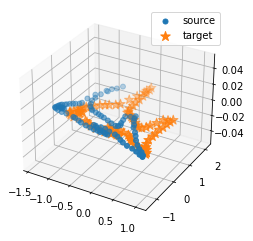

In [2]:
# source, target = utils.prepare_source_and_target_nonrigid_3d('face-x.txt',
#                                                              'face-y.txt', 5.0)
source, target = utils.prepare_source_and_target_nonrigid_3d('fish-x.txt', 'fish-y.txt', 0.001)
source_np = np.asarray(source.points)
target_np = np.asarray(target.points)

# fig = go.Figure(data=[go.Scatter3d(x=source_np[:,0], y=source_np[:,1], z=source_np[:,2],
#                                    mode='markers',    marker=dict( size=1, color='green',  opacity=1.0)), 
#                                    go.Scatter3d(x=target_np[:,0], y=target_np[:,1], z=target_np[:,2],
#                                    mode='markers',    marker=dict( size=1, color='red',  opacity=1.0)) ])
# fig.show()
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.scatter(source_np[:,0], source_np[:,1], source_np[:,2], marker = '.', label = 'source', s = 100.0 )
ax.scatter(target_np[:,0], target_np[:,1], target_np[:,2], marker = '*', label = 'target', s = 100.0 )
plt.legend()
# plt.show()
# plt.ion()
#  <! ![assasa](face_reg.png) >

dada ad asdsada ad  

In [57]:
EstepResult = namedtuple('EstepResult', ['pt1', 'p1', 'px', 'n_p'])
MstepResult = namedtuple('MstepResult', ['transformation', 'sigma2', 'q'])

# @six.add_metaclass(abc.ABCMeta)
class CoherentPointDrift():
    """Coherent Point Drift algorithm.
    This is an abstract class.
    Based on this class, it is inherited by rigid, affine, nonrigid classes
    according to the type of transformation.
    In this class, Estimation step in EM algorithm is implemented and
    Maximazation step is implemented in the inherited classes.

    Args:
        source (numpy.ndarray, optional): Source point cloud data.
        use_cuda (bool, optional): Use CUDA.
    """
    def __init__(self, source=None, use_cuda=False):
        self._source = source
        self._tf_type = None
        self._callbacks = []
        if use_cuda:
            import cupy as cp
            from . import cupy_utils
            self.xp = cp
            self.cupy_utils = cupy_utils
            self._squared_kernel_sum = cupy_utils.squared_kernel_sum
        else:
            self.xp = np
            self._squared_kernel_sum = mu.squared_kernel_sum

    def set_source(self, source):
        self._source = source

    def set_callbacks(self, callbacks):
        self._callbacks.extend(callbacks)

    # @abc.abstractmethod
    def _initialize(self, target):
        return MstepResult(None, None, None)

    def expectation_step(self, t_source, target, sigma2, w=0.0):
        """Expectation step for CPD
        """
        assert t_source.ndim == 2 and target.ndim == 2, "source and target must have 2 dimensions."
        pmat = self.xp.stack([self.xp.sum(self.xp.square(target - ts), axis=1) for ts in t_source])
        pmat = self.xp.exp(-pmat / (2.0 * sigma2))

        c = (2.0 * np.pi * sigma2) ** (t_source.shape[1] * 0.5)
        c *= w / (1.0 - w) * t_source.shape[0] / target.shape[0]
        den = self.xp.sum(pmat, axis=0)
        den[den==0] = self.xp.finfo(np.float32).eps
        den += c

        pmat  = self.xp.divide(pmat, den)
        pt1 = self.xp.sum(pmat, axis=0)
        p1  = self.xp.sum(pmat, axis=1)
        px = self.xp.dot(pmat, target)
        return EstepResult(pt1, p1, px, np.sum(p1))

    def maximization_step(self, target, estep_res, sigma2_p=None):
        return self._maximization_step(self._source, target, estep_res, sigma2_p, xp=self.xp)

    @staticmethod
    # @abc.abstractmethod
    def _maximization_step(source, target, estep_res, sigma2_p=None, xp=np):
        return None

    def registration(self, target, w=0.0,
                     maxiter=50, tol=0.001):
        assert not self._tf_type is None, "transformation type is None."
        res = self._initialize(target)
        q = res.q
        for i in range(maxiter):
            t_source = res.transformation.transform(self._source)
            estep_res = self.expectation_step(t_source, target, res.sigma2, w)
            res = self.maximization_step(target, estep_res, res.sigma2)
            for c in self._callbacks:
                c(res.transformation)
            log.debug("Iteration: {}, Criteria: {}".format(i, res.q))
            if abs(res.q - q) < tol:
                break
            q = res.q
        return res

In [58]:
class NonRigidCPD(CoherentPointDrift):
    """Coherent Point Drift for nonrigid transformation.

    Args:
        source (numpy.ndarray, optional): Source point cloud data.
        beta (float, optional): Parameter of RBF kernel.
        lmd (float, optional): Parameter for regularization term.
        use_cuda (bool, optional): Use CUDA.
    """
    def __init__(self, source=None, beta=2.0, lmd=2.0, use_cuda=False):
        super(NonRigidCPD, self).__init__(source, use_cuda)
        self._tf_type = tf.NonRigidTransformation
        self._beta = beta
        self._lmd = lmd
        self._tf_obj = None
        if not self._source is None:
            self._tf_obj = self._tf_type(None, self._source, self._beta, self.xp)
        self.all_transforms = [] # <-- keep tracks of all the transforms

    def set_source(self, source):
        self._source = source
        self._tf_obj = self._tf_type(None, self._source, self._beta)

    def maximization_step(self, target, estep_res, sigma2_p=None):
        return self._maximization_step(self._source, target, estep_res,
                                       sigma2_p, self._tf_obj, self._lmd, self.xp)

    def _initialize(self, target):
        dim = self._source.shape[1]
        sigma2 = self._squared_kernel_sum(self._source, target)
        q = 1.0 + target.shape[0] * dim * 0.5 * np.log(sigma2)
        self._tf_obj.w = self.xp.zeros_like(self._source)
        return MstepResult(self._tf_obj, sigma2, q)

    # @staticmethod
    def _maximization_step(self,source, target, estep_res, sigma2_p, tf_obj, lmd, xp=np):
        pt1, p1, px, n_p = estep_res
        dim = source.shape[1]
        w = xp.linalg.solve((p1 * tf_obj.g).T + lmd * sigma2_p * xp.identity(source.shape[0]),
                            px - (source.T * p1).T)
        t = source + xp.dot(tf_obj.g, w)
        tr_xp1x = xp.trace(xp.dot(target.T * pt1, target))
        tr_pxt = xp.trace(xp.dot(px.T, t))
        tr_tpt = xp.trace(xp.dot(t.T * p1, t))
        sigma2 = (tr_xp1x - 2.0 * tr_pxt + tr_tpt) / (n_p * dim)
        tf_obj.w = w

        self.all_transforms.append(xp.dot(tf_obj.g, tf_obj.w))
        return MstepResult(tf_obj, sigma2, sigma2)




In [59]:
use_cuda = False 
cp = np
to_cpu = lambda x: x

source_pt = cp.asarray(source.points, dtype=cp.float32)
target_pt = cp.asarray(target.points, dtype=cp.float32)

acpd = NonRigidCPD(source_pt, use_cuda=use_cuda)
start = time.time()
tf_param, _, _ = acpd.registration(target_pt)
elapsed = time.time() - start
# print(acpd.all_transforms[0],'<>')
print("time:{0:2f} secs.,   # EM iterations {1:d}".format(elapsed, len(acpd.all_transforms)))


time:0.226225 secs.,   # EM iterations 9


Animating every step of the registration

In [60]:
src_ = source_pt[:,0:2]
tmp_ = target_pt[:,0:2]

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

ax.scatter(target_pt[:,0], target_pt[:,1], marker = '*', label = 'target', s = 100.0)
for i in range(9):
    src_step = src_ + acpd.all_transforms[i][:,0:2]
    ax.scatter(src_step[:,0], src_step[:,1], marker = '.', label = 'src @ step {}'.format(i), s = 50.0)
    plt.legend()
    # plt.ion()
    plt.ioff()
    # plt.show()

## ---- ## 

In [62]:
# plotting the correspondences found across step a -- b 
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

a, b = 2, 7 # looks most meaningful

ax.scatter(target_pt[:,0], target_pt[:,1], marker = '*', label = 'target', s = 100.0)

src_at_step_a = src_ + acpd.all_transforms[a][:,0:2]
src_at_step_b = src_ + acpd.all_transforms[b][:,0:2]

ax.scatter(src_at_step_a[:,0], src_at_step_a[:,1], marker = 'o', label = 'src @ step {}'.format(a), s = 100.0)
ax.scatter(src_at_step_b[:,0], src_at_step_b[:,1], marker = '^', label = 'src @ step {}'.format(b), s = 100.0)
U = src_at_step_b[:,0] -  src_at_step_a[:,0]
V = src_at_step_b[:,1] -  src_at_step_a[:,1]
W = np.zeros_like(U)
ax.quiver(src_at_step_a[:,0], src_at_step_a[:,1], np.zeros_like(src_at_step_a[:,1]) , U, V, W, label = 'drift') #, np.ones_like(src_at_step_a[:,1]), 'xy' )
plt.legend()
plt.ion()
# plt.ioff()